In [1]:
! pip install pandas
! pip install boto3
! pip install watchtower
! pip install s3fs==0.4.2
! pip install pyathena
! pip install matplotlib
! pip install scipy
! pip install ipywidgets
! pip install scikit-learn

! conda install -c conda-forge --yes implicit 

! pip install --upgrade jupyter_client # useful to make ipywidgets work properly when fitting data with implicit

# pip install git+https://gitlab.com/cloena/cloena-aws-tools.git

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrad

In [1]:
import pandas as pd

import s3fs

import pickle

import implicit

#from aws_tools import athena_tools, s3_tools

import matplotlib

import re

import scipy

from ipywidgets import FloatProgress

import numpy as np

from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

In [2]:
_v = '_v0.2'

In [3]:
data_views = pd.read_csv('s3://bt-data-science-playground/bt-tv-recommendation-system/model_objects/historicalviews'+_v+'.csv')
data_purren = pd.read_csv('s3://bt-data-science-playground/bt-tv-recommendation-system/model_objects/historicalpurchasesrentals'+_v+'.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
season_to_brand_map = pd.read_csv('s3://bt-data-science-playground/bt-tv-recommendation-system/model_objects/SeasonToBrandMapping-NoExpired.csv')

In [5]:
season_to_brand_map.head()

,SEASON_GUID,BRAND_GUID
0,movida_10002812,movida_16370
1,movida_10071830,movida_18508
2,movida_10020242,movida_15374
3,movida_10086096,movida_16208
4,movida_10013947,movida_18907


In [6]:
season_to_brand_map[season_to_brand_map['SEASON_GUID'] == 'movida_10008002']

,SEASON_GUID,BRAND_GUID
1756,movida_10008002,movida_52859


In [7]:
def season_to_brand(df, df_map):
    df = df.merge(df_map, how='left', left_on = 'ID_EDITORIAL', right_on = 'SEASON_GUID')
    df['BRAND_GUID'].fillna(df['ID_EDITORIAL'], inplace=True)
    df['ID_EDITORIAL'] = df['BRAND_GUID']
    df.drop(['SEASON_GUID', 'BRAND_GUID'], axis=1, inplace=True)
    
    return df

In [8]:
data_views = season_to_brand(data_views, season_to_brand_map)

In [9]:
data_purren = season_to_brand(data_purren, season_to_brand_map)

In [10]:
data_views.head()

,ID_USER,TYPE_SLOT,TYPE_ASSET,VIEW_DATE,TITLE,TYPE,END_DATE,ID_EDITORIAL,GENRE,RATING
0,BBEU32029145,Feature,episode,2019-06-29 16:09:09,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_52859,6 Years +,u
1,BBEU29937057,Feature,episode,2019-06-29 08:27:09,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_52859,6 Years +,u
2,BBEU33421092,Feature,episode,2019-06-29 18:38:24,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_52859,6 Years +,u
3,BBEU18833349,Feature,episode,2019-06-29 16:22:29,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_52859,6 Years +,u
4,BBEU27799836,Feature,episode,2019-06-29 08:11:53,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_52859,6 Years +,u


In [11]:
data_purren.head()

,ID_USER,TYPE_ASSET,TYPE_ENTITLEMENT,PRICE,PURCHASE_DATE,TITLE,TYPE,END_DATE,ID_EDITORIAL,GENRE,RATING
0,BBEU05449846,Film,TVOD,4.49,2020-05-27 00:03:22,Bad Boys for Life,film,2020-09-12 22:59:00,BBJ2550316A,Action,15
1,BBEU37034914,Film,TVOD,4.49,2020-05-27 08:52:36,Bad Boys for Life,film,2020-09-12 22:59:00,BBJ2550316A,Action,15
2,BBEU34520852,Film,TVOD,4.49,2020-05-27 09:27:01,Bad Boys for Life,film,2020-09-12 22:59:00,BBJ2550316A,Action,15
3,BBEU36931493,Film,TVOD,4.49,2020-05-27 13:15:53,Bad Boys for Life,film,2020-09-12 22:59:00,BBJ2550316A,Action,15
4,BBEU08836976,Film,TVOD,4.49,2020-05-27 13:07:31,Bad Boys for Life,film,2020-09-12 22:59:00,BBJ2550316A,Action,15


In [12]:
data_views['TYPE'].unique()

array(['season', 'music', 'film', 'collection', 'episode', 'preview'],
      dtype=object)

In [13]:
data_purren['TYPE'].unique()

array(['film', 'collection', 'season', 'music', 'episode'], dtype=object)

In [14]:
data_views['TYPE_ASSET'].unique()

array(['episode', 'music', 'film'], dtype=object)

In [15]:
data_views = data_views.rename(columns={'VIEW_DATE': 'EVENT_DATE'})
data_purren = data_purren.rename(columns={'PURCHASE_DATE': 'EVENT_DATE'})

data_views['TYPE_ENTITLEMENT'] = 'VIEW'

In [16]:
cols = ['ID_USER', 'ID_EDITORIAL', 'TITLE', 'GENRE', 'RATING', 'TYPE', 'TYPE_ASSET', 'END_DATE', 'EVENT_DATE', 'TYPE_ENTITLEMENT']

data_views = data_views[cols]
data_purren = data_purren[cols]

data_implicit = data_views.append(data_purren, ignore_index=True)
del data_views
del data_purren

In [17]:
DROP_MUSIC = True
if DROP_MUSIC:
    data_implicit = data_implicit[data_implicit['TYPE_ASSET'] != 'Music']
else:
    pass

In [18]:
# Calculate sparsity 
n_users = data_implicit['ID_USER'].unique().shape[0]
n_items = data_implicit['ID_EDITORIAL'].unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of items: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(data_implicit.shape[0]) / float(n_users*n_items) * 100))

Number of users: 961307
Number of items: 22781
Sparsity: 0.271%


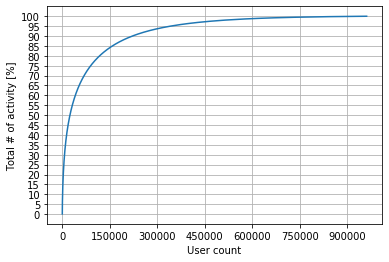

In [19]:
# Calculate how many users have watched X% of the content
idx = data_implicit['ID_USER'].value_counts().index.tolist()
counts = data_implicit['ID_USER'].value_counts().tolist()

user_count = []
percentage_activity = []
activity_so_far = 0
total_activity = sum(counts)

for u in range(len(idx)):
    
    user_count.append(u+1)
    
    activity_so_far = activity_so_far + counts[u]
    percentage_so_far = activity_so_far / total_activity * 100
    percentage_activity.append(percentage_so_far)
     
import matplotlib.pyplot as plt

plt.plot(user_count, percentage_activity)
plt.xlabel('User count')
plt.ylabel('Total # of activity [%]')
plt.grid()
plt.yticks(np.arange(0,105, 5))
plt.xticks(np.arange(0,1000000, 150000))
plt.show()

In [20]:
data_implicit['TYPE_ENTITLEMENT'].value_counts()

VIEW    56764816
TVOD     1570726
EVOD      813002
PPV        96561
Name: TYPE_ENTITLEMENT, dtype: int64

In [21]:
# based on type of entitlement (purchase/rental/ppv/view) give different strength [EVOD=purchase;TVOD=rental]
def assign_eventStrength(x):
    if x == 'EVOD':
        val = 3
    elif x == 'TVOD':
        val = 2
    elif x == 'PPV':
        val = 3
    elif x == 'VIEW':
        val = 1
    else:
        val = 1
    return val

data_implicit['eventStrength'] = data_implicit['TYPE_ENTITLEMENT'].apply(assign_eventStrength)

In [22]:
# Turn duplicate the RATING column in a form that is numeric so that they can be compared
def rating_toNumeric(x):
    if x == 'u':
        return 0
    elif x == 'pg':
        return 1
    elif x == '12':
        return 2
    elif x == '15':
        return 3
    elif x == '18':
        return 4
    else:
        return 5
    
data_implicit['RATING_n'] = data_implicit['RATING'].apply(rating_toNumeric)

In [23]:
def type_production(x):
    if (x == 'season') or (x == 'episode'):
        return 'BRAND'
    elif x == 'collection':
        return 'COLLECTION'
    else:
        return 'PROGRAM'
    
data_implicit['TYPE_PRODUCTION'] = data_implicit['TYPE'].apply(type_production)

In [24]:
data_implicit.head()

,ID_USER,ID_EDITORIAL,TITLE,GENRE,RATING,TYPE,TYPE_ASSET,END_DATE,EVENT_DATE,TYPE_ENTITLEMENT,eventStrength,RATING_n,TYPE_PRODUCTION
0,BBEU32029145,movida_52859,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 16:09:09,VIEW,1,0,BRAND
1,BBEU29937057,movida_52859,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 08:27:09,VIEW,1,0,BRAND
2,BBEU33421092,movida_52859,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 18:38:24,VIEW,1,0,BRAND
3,BBEU18833349,movida_52859,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 16:22:29,VIEW,1,0,BRAND
4,BBEU27799836,movida_52859,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 08:11:53,VIEW,1,0,BRAND


In [25]:
data_implicit['TITLE'] = data_implicit['TITLE'].astype("category")
data_implicit['ID_USER'] = data_implicit['ID_USER'].astype("category")
data_implicit['ID_EDITORIAL'] = data_implicit['ID_EDITORIAL'].astype("category")
data_implicit['ID_USER_simple'] = data_implicit['ID_USER'].cat.codes
data_implicit['ID_EDITORIAL_simple'] = data_implicit['ID_EDITORIAL'].cat.codes

data_implicit.head()

,ID_USER,ID_EDITORIAL,TITLE,GENRE,RATING,TYPE,TYPE_ASSET,END_DATE,EVENT_DATE,TYPE_ENTITLEMENT,eventStrength,RATING_n,TYPE_PRODUCTION,ID_USER_simple,ID_EDITORIAL_simple
0,BBEU32029145,movida_52859,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 16:09:09,VIEW,1,0,BRAND,810934,22155
1,BBEU29937057,movida_52859,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 08:27:09,VIEW,1,0,BRAND,754480,22155
2,BBEU33421092,movida_52859,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 18:38:24,VIEW,1,0,BRAND,847352,22155
3,BBEU18833349,movida_52859,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 16:22:29,VIEW,1,0,BRAND,364895,22155
4,BBEU27799836,movida_52859,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 08:11:53,VIEW,1,0,BRAND,662082,22155


In [26]:
sparse_content_person = scipy.sparse.csr_matrix(
    (data_implicit['eventStrength'].astype(float), (data_implicit['ID_EDITORIAL_simple'], data_implicit['ID_USER_simple']))
)
sparse_person_content = scipy.sparse.csr_matrix(
    (data_implicit['eventStrength'].astype(float), (data_implicit['ID_USER_simple'], data_implicit['ID_EDITORIAL_simple']))
)

In [27]:
%%time

model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.1, iterations=50)
alpha = 15
data_tofit = (sparse_content_person * alpha).astype('double')
model.fit(data_tofit)


CPU times: user 13min 52s, sys: 2.14 s, total: 13min 54s
Wall time: 55.9 s


In [28]:
# Get the trained person and content vectors. We convert them to csr matrices
person_vecs = scipy.sparse.csr_matrix(model.user_factors)
content_vecs = scipy.sparse.csr_matrix(model.item_factors)

In [19]:
# one hot encode the genre tag to add as features for the More Like This

genres = data_implicit[['ID_EDITORIAL_simple', 'TITLE', 'GENRE']]
genres = genres.drop_duplicates(subset='ID_EDITORIAL_simple')
genres = genres.sort_values(by='ID_EDITORIAL_simple').reset_index(drop=True)
genres.head()

,ID_EDITORIAL_simple,TITLE,GENRE
0,0,Day 4 - Pt 3,Tennis
1,1,Athletics: EAA Classic - Lucerne Pt1,Athletics
2,2,Athletics: EAA Classic - Lucerne Pt2,Athletics
3,3,Stage 11 - Highlights,Motor Sport
4,4,6 Hours of Silverstone - Review,Motorsport


In [20]:
genres_dummies = pd.get_dummies(genres['GENRE'], prefix='GENRE')

genres_dummies.head()

,GENRE_2 - 5 Years,GENRE_6 Years +,GENRE_Action,GENRE_Adventure,GENRE_All,GENRE_Alternative Rock,GENRE_Animation,GENRE_Athletics,GENRE_Aussie Rules Football,GENRE_Baby,...,GENRE_Thriller,GENRE_UFC,GENRE_Water Sports,GENRE_Watersports,GENRE_Western,GENRE_Westerns,GENRE_Wintersports,GENRE_World Cinema,GENRE_Wrestling,GENRE_eSports
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
content_id = 9829

n_similar = np.shape(model.item_factors)[0] #20

content_vecs = model.item_factors

content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1)) # i.e. calculating abs. value of the vector of each item -->  |A|

scores = content_vecs.dot(content_vecs[content_id,:])  / (content_norms * content_vecs[content_id,:].sum()) # i.e. calculating cosine similarity, (A.B) / (|A| x |B|) --> |B| just a constant so effectively won't need it

In [41]:
ID_EDITORIAL_legend = data_implicit[['ID_EDITORIAL', 'ID_EDITORIAL_simple', 'TYPE_PRODUCTION']].drop_duplicates(subset=['ID_EDITORIAL', 'ID_EDITORIAL_simple']).sort_values(by='ID_EDITORIAL_simple')

ID_EDITORIAL_simple_list = ID_EDITORIAL_legend['ID_EDITORIAL_simple'].tolist()
ID_EDITORIAL_list = ID_EDITORIAL_legend['ID_EDITORIAL'].tolist()
TYPE_PRODUCTION_list = ID_EDITORIAL_legend['TYPE_PRODUCTION'].tolist()

In [58]:
similar = sorted(zip(ID_EDITORIAL_list, scores[ID_EDITORIAL_simple_list]), key=lambda x: -x[1])

In [108]:
def more_like_this(content_id):
    
    n_similar = np.shape(model.item_factors)[0] #20
    
    content_vecs = model.item_factors

#     # trasnform to dataframe to stack with genre one hot encoded features
#     content_vecs = pd.DataFrame(content_vecs)
    
#     GENRE_FACTORS = False
#     if GENRE_FACTORS:
#         # create list of feature dataframes to stack in case one of the sets needs to be multiplied to make more prominent
#         # can improve by looking at size of features of the two sets, e.g. if one hot encoding gives 90 features vs 30 chosen for synthetic ones genre will automatically be more important and synthetic sets may need to be multiplied by an equivalent factor
#         importance_syntheticFeatures = 6
#         importance_onehotencodedFeatures = 1
#         to_stack = [content_vecs]*importance_syntheticFeatures + [genres_dummies]*importance_onehotencodedFeatures

#         # Stack horizontally features coming from collaborativ filtering & genre one hot encoding
#         content_vecs = pd.concat(to_stack, axis=1)

    # cosine similarity where A is any item, and B is the item of interest
    content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1)) # i.e. calculating abs. value of the vector of each item -->  |A|

    scores = content_vecs.dot(content_vecs.iloc[content_id,:])  / (content_norms * content_vecs.iloc[content_id,:].sum()) # i.e. calculating cosine similarity, (A.B) / (|A| x |B|) --> |B| just a constant so effectively won't need it

    top_idx = scores.argsort() 

    similar = sorted(zip(top_idx, scores[top_idx]), key=lambda x: -x[1])
    
    titles = []
    scores = []
    content_ids = []
    types = []
    
    EDITORIAL_RULES = False
    if EDITORIAL_RULES:
        counter = 1
        for content in similar:
            if counter <= n_similar:

                idx, score = content

                # show only if still available 
                if pd.to_datetime(data_implicit['END_DATE'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0]) > datetime.now():

                    # show only if rating is as selected item or lower
                    if data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0] <= data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == content_id].iloc[0]:

                        titles.append(data_implicit['TITLE'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0])
                        scores.append(score)
                        content_ids.append(idx)
                        types.append(data_implicit['TYPE_PRODUCTION'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0])

                        counter = counter + 1
            else:
                break
        
        recommendations = pd.DataFrame({'title': titles, 'score': scores, 'ids' : content_ids, 'TYPE_PRODUCTION' : types})
    
    else:
        
        recommendations = pd.DataFrame({'score': [i[1] for i in similar], 'ids' : [i[0] for i in similar]})
    
    return recommendations

In [102]:
#data_implicit[data_implicit['TITLE'].str.lower().str.contains("moana")].head(3)
data_implicit[data_implicit['TITLE']=='Frozen'].head(1)

,ID_USER,ID_EDITORIAL,TITLE,GENRE,RATING,TYPE,TYPE_ASSET,END_DATE,EVENT_DATE,TYPE_ENTITLEMENT,eventStrength,RATING_n,TYPE_PRODUCTION,ID_USER_simple,ID_EDITORIAL_simple
11679880,BBEU14614435,BBJ316779IOC,Frozen,Animation,pg,film,film,2022-01-02 23:59:00,2019-06-29 16:36:16,VIEW,1,1,PROGRAM,279907,9829


In [109]:
recs_MLT = more_like_this(9829)

In [110]:
len(recs_MLT)

22781

In [111]:
recs_MLT = recs_MLT.merge(data_implicit, how='left', left_on='ids', right_on='ID_EDITORIAL_simple').drop_duplicates(subset='ID_EDITORIAL')

In [112]:
recs_MLT.head()

,score,ids,ID_USER,ID_EDITORIAL,TITLE,GENRE,RATING,TYPE,TYPE_ASSET,END_DATE,EVENT_DATE,TYPE_ENTITLEMENT,eventStrength,RATING_n,TYPE_PRODUCTION,ID_USER_simple,ID_EDITORIAL_simple
0,0.955123,9829,BBEU14614435,BBJ316779IOC,Frozen,Animation,pg,film,film,2022-01-02 23:59:00,2019-06-29 16:36:16,VIEW,1,1,PROGRAM,279907,9829
89434,0.904360,1701,BBEU21690472,BBJ1288035A,Moana,Animation,pg,film,film,2025-01-31 23:59:00,2019-06-29 16:26:51,VIEW,1,1,PROGRAM,462027,1701
172711,0.885321,9817,BBEU20674236,BBJ316743HVOD,Toy Story,Animation,pg,film,film,2022-01-02 23:59:00,2019-06-29 07:26:17,VIEW,1,1,PROGRAM,431102,9817
209763,0.860086,1518,BBEU22561922,BBJ1236748A,Trolls,Family,u,film,film,2017-07-12 22:59:00,2019-06-29 16:39:26,VIEW,1,0,PROGRAM,486289,1518
258914,0.849648,9819,BBEU24437925,BBJ316749HVOD,Toy Story 3,Animation,u,film,film,2025-12-31 23:59:00,2019-06-29 16:15:36,VIEW,1,0,PROGRAM,547404,9819


In [114]:
#### create the data in json-like format --- More Like This
MLT_ids = [9815, 9829]


output = {}

for i in MLT_ids:
    
    recs_MLT = more_like_this(i)
    recs_MLT = recs_MLT.merge(data_implicit, how='left', left_on='ids', right_on='ID_EDITORIAL_simple').drop_duplicates(subset='ID_EDITORIAL')

    recs = {}
    for index, row in recs_MLT.iterrows():

        recs[row['ID_EDITORIAL']] = {
            'score' : row['score'],
            'type' : row['TYPE_PRODUCTION']
        }
    
    output[data_implicit[data_implicit['ID_EDITORIAL_simple']==i]['ID_EDITORIAL'].iloc[0]] = recs

In [116]:
import json
import boto3    
s3 = boto3.resource('s3')
s3object = s3.Object('bt-data-science-playground', 'bt-tv-recommendation-system/output/StaticData_MoreLikeThis.json')

s3object.put(
    Body=(bytes(json.dumps(output).encode('UTF-8')))
)

{'ResponseMetadata': {'RequestId': '3N9Z3W4KAS5T8WCG',
  'HostId': 'T9F1RPI8T/4tI5haMevL/HEKoZRg5tCM4i51odHxJ33x0xzZetSCsJ3ld9uy1EKqVerN8RjDwiE=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'T9F1RPI8T/4tI5haMevL/HEKoZRg5tCM4i51odHxJ33x0xzZetSCsJ3ld9uy1EKqVerN8RjDwiE=',
   'x-amz-request-id': '3N9Z3W4KAS5T8WCG',
   'date': 'Thu, 29 Oct 2020 10:24:03 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"a1f87ec7bf9207cca12f08900ae4daf2"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"a1f87ec7bf9207cca12f08900ae4daf2"',
 'ServerSideEncryption': 'AES256'}

In [162]:
### send to dynamoDB table --- More Like This
import boto3
from decimal import Decimal
boto_client = boto3.setup_default_session(region_name='eu-west-1')

def put_recs(item_id, recs_list, type_list, score_list, dynamodb=None):
    if not dynamodb:
        dynamodb = boto3.resource('dynamodb')

    table = dynamodb.Table('MoreLikeThis')
    response = table.put_item(
       Item={
           'item_id': item_id,
           'item_recs': recs_list,
           'item_type' : type_list,
           'item_score' : score_list
        }
    )
    return response

In [163]:
recs_resp = put_recs(
    data_implicit[data_implicit['ID_EDITORIAL_simple']==13524]['ID_EDITORIAL'].iloc[0],
    recs_MLT['ID_EDITORIAL'].tolist(),
    recs_MLT['type_production'].tolist(),
    [Decimal(x) for x in recs_MLT['score'].tolist()]
)

In [167]:
front_page = ["BBJ2740610A","BBJ2746794A","BBJ2759734A","BBJ2610525A","BBJ2749022A","BBJ2733427A","BBJ2758182A","BBJ2798541A","BBJ2586080A","BBJ2620256A","BBJ2792748A","BBJ2762267A","BBJ2756770A","BBJ2736286A","BBJ2615958A","BBJ2550481A","BBJ2615418A","BBJ2619263A","BBJ2586586A","BBJ2778982A","BBJ2803388A"]

In [189]:
front_page = ['BBJ1621567A']

In [190]:
len(front_page)

1

In [191]:
def replace_item_simple_id(x):
    return data_implicit[data_implicit['ID_EDITORIAL']==x]['ID_EDITORIAL_simple'].iloc[0]

front_page_simple = [replace_item_simple_id(x) for x in front_page if x in data_implicit['ID_EDITORIAL'].tolist()]

In [192]:
len(front_page_simple)

1

In [193]:
for jjj in front_page_simple:# data_implicit['ID_EDITORIAL_simple'].unique().tolist():
            
        recs_MLT = more_like_this(jjj)

        recs_MLT = recs_MLT.merge(data_implicit, how='left', left_on='ids', right_on='ID_EDITORIAL_simple').drop_duplicates(subset='ID_EDITORIAL')

        recs_resp = put_recs(
            data_implicit[data_implicit['ID_EDITORIAL_simple']==jjj]['ID_EDITORIAL'].iloc[0],
            recs_MLT['ID_EDITORIAL'].tolist(),
            recs_MLT['type_production'].tolist(),
            [Decimal(x) for x in recs_MLT['score'].tolist()]
        )

In [40]:
content_id = 9829

n_similar = np.shape(model.item_factors)[0] #20

content_vecs = model.item_factors

content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1)) # i.e. calculating abs. value of the vector of each item -->  |A|

scores = content_vecs.dot(content_vecs[content_id,:])  / (content_norms * content_vecs[content_id,:].sum()) # i.e. calculating cosine similarity, (A.B) / (|A| x |B|) --> |B| just a constant so effectively won't need it

In [41]:
ID_EDITORIAL_legend = data_implicit[['ID_EDITORIAL', 'ID_EDITORIAL_simple', 'TYPE_PRODUCTION']].drop_duplicates(subset=['ID_EDITORIAL', 'ID_EDITORIAL_simple']).sort_values(by='ID_EDITORIAL_simple')

ID_EDITORIAL_simple_list = ID_EDITORIAL_legend['ID_EDITORIAL_simple'].tolist()
ID_EDITORIAL_list = ID_EDITORIAL_legend['ID_EDITORIAL'].tolist()
TYPE_PRODUCTION_list = ID_EDITORIAL_legend['TYPE_PRODUCTION'].tolist()

In [58]:
similar = sorted(zip(ID_EDITORIAL_list, scores[ID_EDITORIAL_simple_list]), key=lambda x: -x[1])

In [90]:
person_id = 22

num_contents = np.shape(model.item_factors)[0] #20

content_vecs_T = content_vecs.T

min_max = MinMaxScaler()

In [91]:
# Get the interactions scores from the sparse person content matrix
person_interactions = sparse_person_content[person_id,:].toarray()

# Add 1 to everything, so that articles with no interaction yet become equal to 1
person_interactions = person_interactions.reshape(-1) + 1

# Make articles already interacted zero
person_interactions[person_interactions > 1] = 0

# Get dot product of person vector and all content vectors
rec_vector = person_vecs[person_id,:].dot(content_vecs_T)

rec_vector = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]

# Multiply by zero the scores of items already interacted with
recommend_vector = person_interactions * rec_vector

In [87]:
ID_EDITORIAL_legend = data_implicit[['ID_EDITORIAL', 'ID_EDITORIAL_simple', 'TYPE_PRODUCTION']].drop_duplicates(subset=['ID_EDITORIAL', 'ID_EDITORIAL_simple']).sort_values(by='ID_EDITORIAL_simple')

ID_EDITORIAL_simple_list = ID_EDITORIAL_legend['ID_EDITORIAL_simple'].tolist()
ID_EDITORIAL_list = ID_EDITORIAL_legend['ID_EDITORIAL'].tolist()
TYPE_PRODUCTION_list = ID_EDITORIAL_legend['TYPE_PRODUCTION'].tolist()

In [92]:
recs = sorted(zip(ID_EDITORIAL_simple_list, recommend_vector[ID_EDITORIAL_simple_list]), key=lambda x: -x[1])

In [124]:
def for_you(person_id):
    
    # Number of content items to get
    num_contents = np.shape(model.item_factors)[0] #20

    # Get the interactions scores from the sparse person content matrix
    person_interactions = sparse_person_content[person_id,:].toarray()
    # Add 1 to everything, so that articles with no interaction yet become equal to 1
    person_interactions = person_interactions.reshape(-1) + 1
    # Make articles already interacted zero
    person_interactions[person_interactions > 1] = 0
    # Get dot product of person vector and all content vectors
    rec_vector = person_vecs[person_id,:].dot(content_vecs.T).toarray()

    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]

    dithering = False
    if dithering:
        # Dithering score is caclulated as:
        # dithScore = log10(rank) + N(0,log10(eps)), where eps is generally between 1.5 & 3.0
        eps = 1.5
        rank = np.argsort(np.argsort(-rec_vector.reshape(-1,1)[:,0])) # for rec_vector_scaled the higher the better
        dithScore = np.log10(rank+1) + np.random.normal(0.0, np.sqrt(np.log10(eps)), len(rank)) # make rank start from 1 not zero
        # for dithScore the lower the better

        # Content already interacted will effectively have their recommendation multiplied by zero
        recommend_vector = person_interactions * (-dithScore + max(dithScore)) # multiply this way to effectively make the best score being the highest again

        content_idx = np.argsort(recommend_vector)[::-1]

    else:
        # Content already interacted will effectively have their recommendation multiplied by zero
        recommend_vector = person_interactions * rec_vector_scaled

        # Sort the indices of the content into order of best recommendations
        content_idx = np.argsort(recommend_vector)[::-1]
    
    EDITORIAL_RULES = False
    if EDITORIAL_RULES:
        # Start empty list to store titles and scores
        titles = []
        scores = []
        content_ids = []

        idx = 0
        counter = 0
        max_user_rating = max(data_implicit['RATING_n'].loc[data_implicit['ID_USER_simple'] == person_id])
        while counter < num_contents:

            # show only if still available 
            if pd.to_datetime(data_implicit['END_DATE'].loc[data_implicit['ID_EDITORIAL_simple'] == content_idx[idx]].iloc[0]) > datetime.now():

                # check that item has rating as or lower of highest watched by user
                if data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == content_idx[idx]].iloc[0] <= max_user_rating:

                    # Append titles and scores to the list
                    titles.append(data_implicit['TITLE'].loc[data_implicit['ID_EDITORIAL_simple'] == content_idx[idx]].iloc[0])
                    scores.append(recommend_vector[content_idx[idx]])
                    content_ids.append(content_idx[idx])

                    counter = counter + 1
            idx = idx + 1
        recommendations = pd.DataFrame({'title': titles, 'score': scores, 'ids' : content_ids})
        
    else:
        recommendations = pd.DataFrame({'score': recommend_vector[content_idx], 'ids' : content_idx})
    
    
    return recommendations

In [137]:
recs_FY = for_you(22)

In [138]:
recs_FY = recs_FY.merge(data_implicit, how='left', left_on='ids', right_on='ID_EDITORIAL_simple').drop_duplicates(subset='ID_EDITORIAL')

In [139]:
recs_FY.head()

,score,ids,ID_USER,ID_EDITORIAL,TITLE,GENRE,RATING,TYPE,TYPE_ASSET,END_DATE,EVENT_DATE,TYPE_ENTITLEMENT,eventStrength,RATING_n,TYPE_PRODUCTION,ID_USER_simple,ID_EDITORIAL_simple
0,0.658019,22416,BBEU04850681,movida_57700,We Hunt Together Series 1,Drama,15,season,episode,2020-07-11 21:00:00,2020-06-23 15:07:07,VIEW,1,3,BRAND,106679,22416
18628,0.655687,20043,BBEU24100692,movida_10067317,Departure Series 1,Drama,15,season,episode,2019-12-06 03:00:00,2019-08-17 08:28:19,VIEW,1,3,BRAND,534417,20043
63856,0.639748,17670,BBEU17980632,movida_10030728,Condor Series 1,NaN,15,season,episode,2020-01-20 03:40:00,2018-11-24 07:51:44,VIEW,1,3,BRAND,341334,17670
108589,0.629760,17494,BBEU05769005,movida_10029547,Special Victims Unit Series 20,NaN,15,season,episode,2020-06-25 02:06:00,2019-05-05 08:27:14,VIEW,1,3,BRAND,127806,17494
166757,0.620892,19539,BBEU04943946,movida_10036630,Proven Innocent Series 1,NaN,15,season,episode,2020-07-14 02:09:00,2019-06-29 16:39:32,VIEW,1,3,BRAND,108691,19539


In [140]:
data_implicit[data_implicit['ID_USER_simple']==22].drop_duplicates(subset='ID_EDITORIAL').head()

,ID_USER,ID_EDITORIAL,TITLE,GENRE,RATING,TYPE,TYPE_ASSET,END_DATE,EVENT_DATE,TYPE_ENTITLEMENT,eventStrength,RATING_n,TYPE_PRODUCTION,ID_USER_simple,ID_EDITORIAL_simple
979113,BBEU00021416,BBJ1822149A,How To Train Your Dragon: The Hidden World,Animation,pg,film,film,2025-12-31 23:59:00,2019-05-24 13:50:53,VIEW,1,1,PROGRAM,22,6031
2057906,BBEU00021416,BBJ1831346A,Bumblebee,Action,pg,film,film,2019-09-14 22:59:00,2019-05-17 19:39:36,VIEW,1,1,PROGRAM,22,6098
8512029,BBEU00021416,movida_10030729,Andi Mack Series 3,6 Years +,u,season,episode,2019-04-02 22:59:00,2019-06-17 08:14:57,VIEW,1,0,BRAND,22,17671
9603076,BBEU00021416,BBJ1707011A,Ocean's 8,Crime,12,film,film,2022-01-02 23:59:00,2019-01-17 10:49:33,VIEW,1,2,PROGRAM,22,4608
10132272,BBEU00021416,BBJ1822125A,The Kid Who Would Be King,Family,pg,film,film,2025-12-31 23:59:00,2019-06-23 19:52:02,VIEW,1,1,PROGRAM,22,6029


In [141]:
#### create the data in json-like format --- For You
FY_ids = [22, 100]


output = {}

for i in FY_ids:
    
    recs_FY = for_you(i)
    recs_FY = recs_FY.merge(data_implicit, how='left', left_on='ids', right_on='ID_EDITORIAL_simple').drop_duplicates(subset='ID_EDITORIAL')

    recs = {}
    for index, row in recs_FY.iterrows():

        recs[row['ID_EDITORIAL']] = {
            'score' : row['score'],
            'type' : row['TYPE_PRODUCTION']
        }
    
    output[data_implicit[data_implicit['ID_USER_simple']==i]['ID_USER'].iloc[0]] = recs

In [142]:
output.keys()

dict_keys(['BBEU00021416', 'BBEU00029503'])

In [143]:
import json
import boto3    
s3 = boto3.resource('s3')
s3object = s3.Object('bt-data-science-playground', 'bt-tv-recommendation-system/output/StaticData_ForYou.json')

s3object.put(
    Body=(bytes(json.dumps(output).encode('UTF-8')))
)

{'ResponseMetadata': {'RequestId': '0404D2EE8597CE0A',
  'HostId': 'liSO86T/VJqbJSgu7n82/lXmW88bYrk1pcebrW/Ve3zk9cUBVn27iC/inX42IRxmlhII4EkcRhA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'liSO86T/VJqbJSgu7n82/lXmW88bYrk1pcebrW/Ve3zk9cUBVn27iC/inX42IRxmlhII4EkcRhA=',
   'x-amz-request-id': '0404D2EE8597CE0A',
   'date': 'Thu, 29 Oct 2020 10:53:00 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"83818d7c143accdf9658fd941f3f08e5"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"83818d7c143accdf9658fd941f3f08e5"',
 'ServerSideEncryption': 'AES256'}

In [81]:
#### create dynamoDB table --- For you

def replace_item_id(x):
    return data_implicit[data_implicit['ID_EDITORIAL_simple']==x]['ID_EDITORIAL'].iloc[0]

In [82]:
recs['ids'] = recs['ids'].apply(replace_item_id)

In [91]:
recs.head()

,title,score,ids
0,Harry Potter and the Philosopher's Stone,0.975630,BBJ956271HVOD
1,Harry Potter and the Goblet of Fire,0.971547,BBJ956277HVOD
2,Harry Potter and the Chamber of Secrets,0.963755,BBJ956273HVOD
3,Harry Potter and the Prisoner of Azkaban,0.955491,BBJ956275HVOD
4,Harry Potter and the Deathly Hallows: Part 2,0.953597,BBJ956287HVOD


In [92]:
recs['type_production'] = recs['ids']

In [93]:
def get_type_production(x):
    return data_implicit[data_implicit['ID_EDITORIAL']==x]['TYPE_PRODUCTION'].iloc[0]

In [94]:
recs['type_production'] = recs['type_production'].apply(get_type_production)

In [95]:
print(recs)

                                                title     score  \
0            Harry Potter and the Philosopher's Stone  0.975630   
1                 Harry Potter and the Goblet of Fire  0.971547   
2             Harry Potter and the Chamber of Secrets  0.963755   
3            Harry Potter and the Prisoner of Azkaban  0.955491   
4        Harry Potter and the Deathly Hallows: Part 2  0.953597   
5                                          Home Alone  0.942034   
6                                   A Wrinkle In Time  0.932164   
7                                             Titanic  0.925042   
8                    Ready Player One [Bonus Edition]  0.915788   
9       Horrible Histories: The Movie - Rotten Romans  0.915296   
10  The Chronicles of Narnia: The Lion, The Witch ...  0.914229   
11                          Ralph Breaks the Internet  0.912425   
12          Hotel Transylvania 3 - A Monster Vacation  0.909495   
13                                             Avatar  0.90466

In [100]:
import boto3
from decimal import Decimal
boto_client = boto3.setup_default_session(region_name='eu-west-1')

def put_recs(user_id, recs_list, type_list, score_list, dynamodb=None):
    if not dynamodb:
        dynamodb = boto3.resource('dynamodb')

    table = dynamodb.Table('ForYou')
    response = table.put_item(
       Item={
           'user_id': user_id,
           'item_id': recs_list,
           'item_type' : type_list,
           'item_score' : score_list
        }
    )
    return response

In [101]:
recs_resp = put_recs(
    'BBEU00021416',
    recs['ids'].tolist(),
    recs['type_production'].tolist(),
    [Decimal(x) for x in recs['score'].tolist()]
)

In [172]:
data_implicit[data_implicit['ID_USER_simple']==118726].drop_duplicates(subset=['TITLE']).head(10)

,ID_USER,ID_EDITORIAL,TITLE,GENRE,RATING,TYPE,TYPE_ASSET,END_DATE,EVENT_DATE,TYPE_ENTITLEMENT,eventStrength,RATING_n,ID_USER_simple,ID_EDITORIAL_simple,TYPE_PRODUCTION
3353873,BBEU05417039,movida_10029269,Fresh Videos This Week,NaN,18,collection,music,2020-06-25 22:59:00,2019-07-05 17:31:44,VIEW,1,5,118726,17434,COLLECTION
6477408,BBEU05417039,movida_52654,Summer Hits,NaN,18,collection,music,2023-03-30 22:59:00,2018-08-07 15:53:35,VIEW,1,4,118726,22141,COLLECTION
6746541,BBEU05417039,movida_10001236,BBQ Bangers,NaN,12,collection,music,2023-03-30 22:59:00,2020-01-09 17:11:14,VIEW,1,2,118726,15578,COLLECTION
6910168,BBEU05417039,movida_10065290,Fresh Hits 2019,NaN,18,collection,music,2023-03-30 22:59:00,2018-11-24 10:02:58,VIEW,1,4,118726,19824,COLLECTION
7716825,BBEU05417039,movida_10078069,BRIT Awards 2020,NaN,18,collection,music,2023-03-30 22:59:00,2019-07-05 14:18:25,VIEW,1,4,118726,20917,COLLECTION
8423460,BBEU05417039,movida_10035075,Lady Gaga,Pop,18,collection,music,2023-03-30 22:59:00,2018-10-27 09:06:40,VIEW,1,4,118726,18411,COLLECTION
8540470,BBEU05417039,movida_63944,Ivor Novellos 2016,NaN,15,collection,music,2023-03-30 22:59:00,2018-08-11 13:38:44,VIEW,1,3,118726,22713,COLLECTION
8959151,BBEU05417039,movida_10036241,Eminem,NaN,18,collection,music,2023-03-30 22:59:00,2019-01-16 15:39:27,VIEW,1,4,118726,19410,COLLECTION
8968702,BBEU05417039,movida_10023876,That Was Then... This Is Now,NaN,18,collection,music,2023-03-30 22:59:00,2019-06-29 16:33:23,VIEW,1,4,118726,16655,COLLECTION
9585369,BBEU05417039,movida_10074001,Editors' Picks 2019,NaN,18,collection,music,2023-03-30 22:59:00,2019-06-29 16:41:08,VIEW,1,4,118726,20798,COLLECTION


In [173]:
data_implicit[data_implicit['TYPE_ASSET']!='music'][data_implicit['ID_USER_simple']==118726].drop_duplicates(subset=['TITLE']).head(10)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,ID_USER,ID_EDITORIAL,TITLE,GENRE,RATING,TYPE,TYPE_ASSET,END_DATE,EVENT_DATE,TYPE_ENTITLEMENT,eventStrength,RATING_n,ID_USER_simple,ID_EDITORIAL_simple,TYPE_PRODUCTION


In [182]:
grpd = data_implicit[data_implicit['TYPE_ASSET']!='music'][['TYPE_ASSET', 'ID_USER']].groupby(by=["ID_USER"]).sum()

KeyboardInterrupt: 

In [183]:
'BBJ2264605A' in data_implicit['ID_EDITORIAL'].tolist()

True